### data 

# 📊 Refactoring NMR Analysis for Reusability

This notebook demonstrates how to **modularize and refactor** the original NMR analysis workflow into clean, reusable components. The aim is to create a flexible and maintainable codebase for future applications, including:

- 📁 **Data loading**
- 🔄 **Fourier transform**
- 🔍 **Peak detection**
- 📈 **Integration**
- 🧪 **Functional group identification**
- ⚛️ **Quantum-level simulation**

All the functions and classes used here are refactored from the original `main_project.ipynb` file.

By restructuring the code into **functions and classes**, we enable:
- 🚀 Faster prototyping
- 🔧 Easier debugging and testing
- ♻️ Reusability across projects
- 📦 Potential packaging into libraries or APIs


## 1. Encapsulate Data Loading and Preprocessing

We'll create a function `load_nmr_data(filepath)` to load and preprocess the NMR data. This function can be extended to handle different file formats or preprocessing steps.

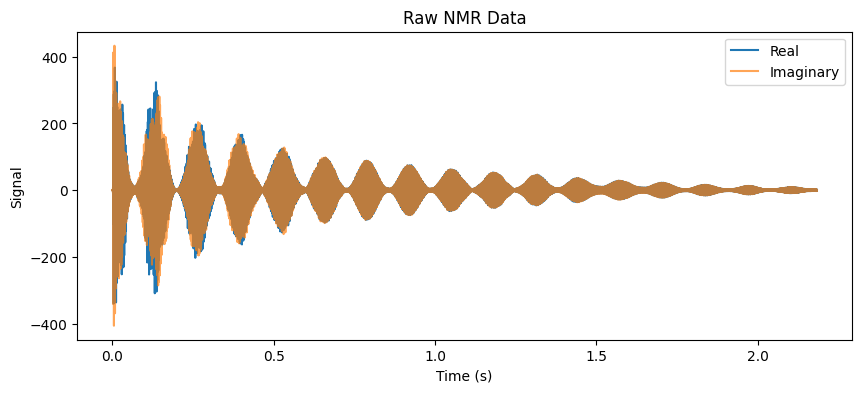

       Time      Real  Imaginary
0  0.000000  0.000003   0.000009
1  0.000133 -0.001235  -0.003140
2  0.000267  0.050601   0.188029
3  0.000400  0.019175   0.365893
4  0.000533 -0.136525  -0.611649


In [17]:
import matplotlib.pyplot as plt

def load_and_visualize_nmr(filepath, delimiter='\t', skip_header=1, columns=('Time', 'Real', 'Imaginary')):
    """
    Load NMR data from a file and plot the real and imaginary parts.
    """
    df = load_nmr_data(filepath, delimiter=delimiter, skip_header=skip_header, columns=columns)
    plt.figure(figsize=(10, 4))
    plt.plot(df["Time"], df["Real"], label="Real")
    if "Imaginary" in df.columns:
        plt.plot(df["Time"], df["Imaginary"], label="Imaginary", alpha=0.7)
    plt.xlabel("Time (s)")
    plt.ylabel("Signal")
    plt.title("Raw NMR Data")
    plt.legend()
    plt.show()
    print(df.head())
    return df

# Example usage:
df = load_and_visualize_nmr("13_03_11_indst_1H fid.asc")

## 2. Refactor Nyquist Frequency Calculation into a Function

We'll define a function `calculate_nyquist_frequency(time_array)` that takes an array of time points and returns the Nyquist frequency. This makes the calculation reusable and clear.

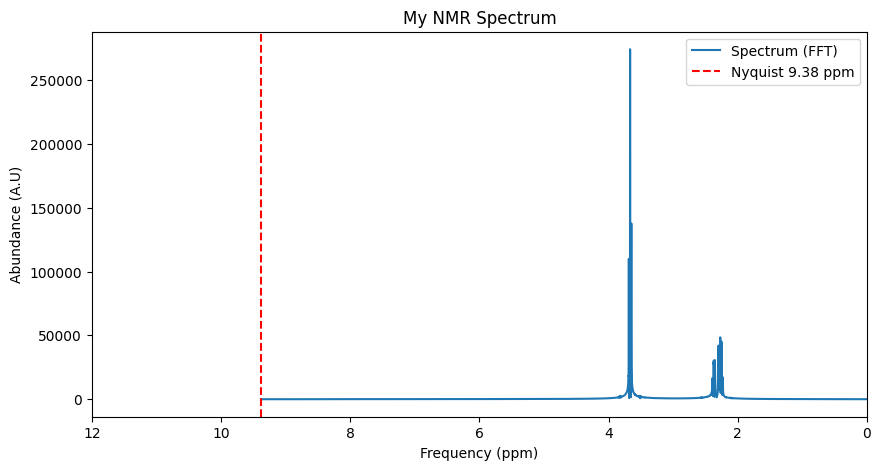

Nyquist frequency: 3751.50 Hz (9.38 ppm), dwell time: 1.3328e-04 s


In [ ]:
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
import numpy as np

def calculate_and_visualize_nyquist_ppm(
    time_array, 
    real_signal, 
    spectrometer_freq_mhz, 
    name="NMR Spectrum"
):
    """
    Calculate and visualize the positive half of the FFT spectrum (in ppm),
    with the x-axis inverted and y-axis as abundance (A.U).
    Also shows the Nyquist frequency as a vertical line.
    
    Parameters:
        time_array (np.ndarray): Time points (seconds).
        real_signal (np.ndarray): Real part of FID.
        spectrometer_freq_mhz (float): Spectrometer frequency in MHz.
        name (str): Plot title.
    """
    if len(time_array) < 2:
        raise ValueError("Need at least two time points to calculate dwell time.")
    dwell_time = time_array[1] - time_array[0]
    nyquist_freq = 1 / (2 * dwell_time)
    
    # FFT
    fft_result = fft(real_signal)
    frequencies = fftfreq(len(real_signal), d=dwell_time)
    fft_magnitude = np.abs(fft_result)
    
    # Positive frequencies only
    mask = frequencies >= 0
    positive_frequencies = frequencies[mask]
    positive_magnitude = fft_magnitude[mask]
    
    # Convert frequency (Hz) to ppm
    freq_ppm = positive_frequencies / spectrometer_freq_mhz

    plt.figure(figsize=(10, 5))
    plt.plot(freq_ppm, positive_magnitude, label="Spectrum (FFT)")
    plt.axvline(nyquist_freq / spectrometer_freq_mhz, color='r', linestyle='--', label=f"Nyquist {nyquist_freq/spectrometer_freq_mhz:.2f} ppm")
    plt.gca().invert_xaxis()  # Invert x-axis
    plt.title(name)
    plt.xlabel("Frequency (ppm)")
    plt.ylabel("Abundance (A.U)")
    plt.xlim(12, 0)  # Typical NMR range, adjust as needed
    plt.legend()
    plt.show()
    
    print(f"Nyquist frequency: {nyquist_freq:.2f} Hz ({nyquist_freq/spectrometer_freq_mhz:.2f} ppm), dwell time: {dwell_time:.4e} s")
    return nyquist_freq
def compute_fft(self):
        dwell_time = self.time[1] - self.time[0]
        self.fft_result = fft(self.real)
        self.frequencies = fftfreq(len(self.real), d=dwell_time)
        self.fft_magnitude = np.abs(self.fft_result)
        return self.frequencies, self.fft_magnitude

# Example usage:
nyquist = calculate_and_visualize_nyquist_ppm(df["Time"].values, df["Real"].values, 399.78219838, name="My NMR Spectrum")

## 3. Create a Class for NMR Spectrum Analysis

We'll define a class `NMRSpectrum` that encapsulates the workflow: loading data, performing FFT, detecting peaks, integrating, and plotting. This class will store relevant attributes and provide methods for each analysis step.

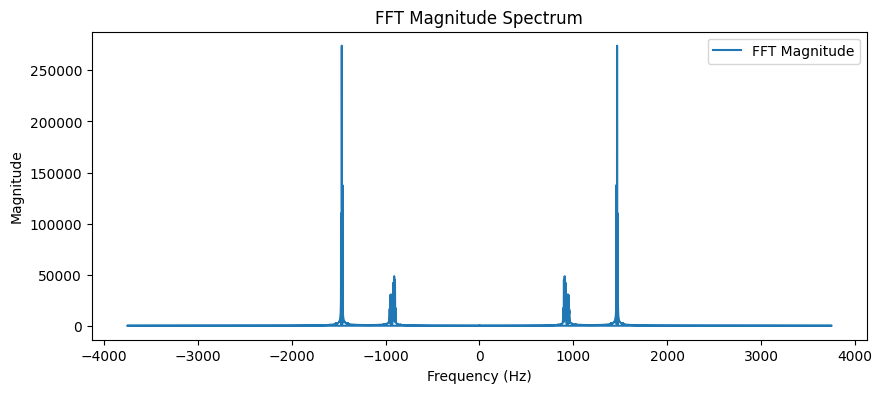

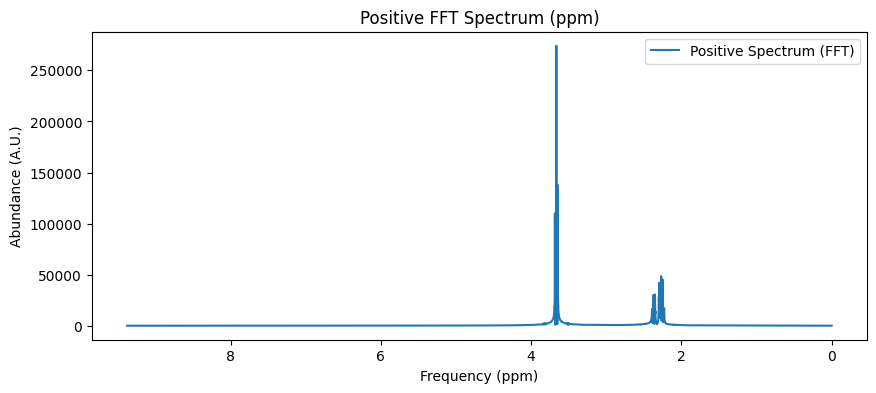

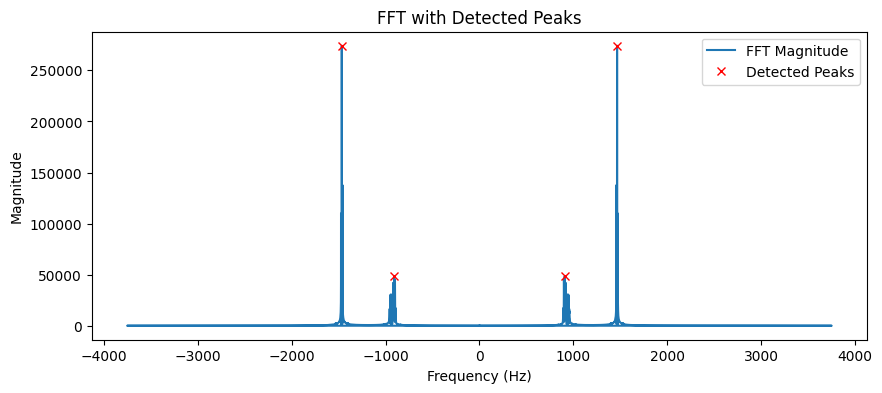

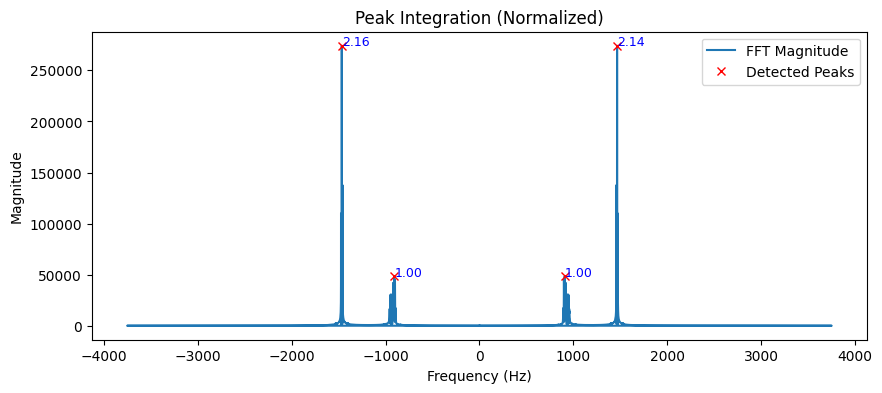

Detected 4 peaks.
Integrated areas: [np.float64(1519835.1745369069), np.float64(3246639.636011379), np.float64(3287932.9063540595), np.float64(1519835.1745369069)]
Normalized integrals: [np.float64(1.0), np.float64(2.13617877149121), np.float64(2.163348342925338), np.float64(1.0)]


In [28]:
import matplotlib.pyplot as plt

def test_and_visualize_nmr_spectrum(spectrum, spectrometer_freq_mhz=400):
    """
    Test NMRSpectrum class and visualize FFT, peaks, and integration.
    """
    # 1. Compute FFT
    freqs, mag = spectrum.compute_fft()
    plt.figure(figsize=(10, 4))
    plt.plot(freqs, mag, label="FFT Magnitude")
    plt.title("FFT Magnitude Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.show()

    # 2. Only positive frequencies, convert to ppm, invert x-axis
    mask = freqs >= 0
    ppm = freqs[mask] / spectrometer_freq_mhz
    mag_pos = mag[mask]
    plt.figure(figsize=(10, 4))
    plt.plot(ppm, mag_pos, label="Positive Spectrum (FFT)")
    plt.gca().invert_xaxis()
    plt.title("Positive FFT Spectrum (ppm)")
    plt.xlabel("Frequency (ppm)")
    plt.ylabel("Abundance (A.U.)")
    plt.legend()
    plt.show()

    # 3. Detect Peaks
    peaks, properties = spectrum.detect_peaks()
    plt.figure(figsize=(10, 4))
    plt.plot(freqs, mag, label="FFT Magnitude")
    plt.plot(freqs[peaks], mag[peaks], "rx", label="Detected Peaks")
    plt.title("FFT with Detected Peaks")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.show()

    # 4. Integrate Peaks
    areas = spectrum.integrate_peaks()
    norm_areas = spectrum.normalize_integrals()
    plt.figure(figsize=(10, 4))
    plt.plot(freqs, mag, label="FFT Magnitude")
    plt.plot(freqs[peaks], mag[peaks], "rx", label="Detected Peaks")
    for i, peak_idx in enumerate(peaks):
        plt.text(freqs[peak_idx], mag[peak_idx], f"{norm_areas[i]:.2f}", color="blue", fontsize=9)
    plt.title("Peak Integration (Normalized)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.show()

    print(f"Detected {len(peaks)} peaks.")
    print("Integrated areas:", areas)
    print("Normalized integrals:", norm_areas)

# Example usage:
spectrum = NMRSpectrum.from_dataframe(df, name="Test Spectrum", spectrometer_freq=400)
test_and_visualize_nmr_spectrum(spectrum, spectrometer_freq_mhz=400)

In [27]:
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import find_peaks
from scipy.integrate import simpson

class NMRSpectrum:
    def __init__(self, time, real, imaginary=None, name=None, spectrometer_freq=None):
        self.time = np.array(time)
        self.real = np.array(real)
        self.imaginary = np.array(imaginary) if imaginary is not None else None
        self.name = name
        self.spectrometer_freq = spectrometer_freq
        self.fft_result = None
        self.frequencies = None
        self.fft_magnitude = None
        self.peaks = None
        self.peak_properties = None
        self.integrated_areas = None

    @classmethod
    def from_dataframe(cls, df, name=None, spectrometer_freq=None):
        return cls(df['Time'], df['Real'], df.get('Imaginary', None), name, spectrometer_freq)

    def compute_fft(self):
        dwell_time = self.time[1] - self.time[0]
        self.fft_result = fft(self.real)
        self.frequencies = fftfreq(len(self.real), d=dwell_time)
        self.fft_magnitude = np.abs(self.fft_result)
        return self.frequencies, self.fft_magnitude

    def detect_peaks(self, height_ratio=0.1, min_distance=100, min_prominence=0.05):
        if self.fft_magnitude is None:
            raise ValueError("Run compute_fft() first.")
        height_threshold = height_ratio * np.max(self.fft_magnitude)
        min_prom = min_prominence * np.max(self.fft_magnitude)
        peaks, properties = find_peaks(
            self.fft_magnitude,
            height=height_threshold,
            distance=min_distance,
            prominence=min_prom
        )
        self.peaks = peaks
        self.peak_properties = properties
        return peaks, properties

    def integrate_peaks(self):
        if self.peaks is None or self.peak_properties is None:
            raise ValueError("Run detect_peaks() first.")
        integrated_areas = []
        for i, peak_idx in enumerate(self.peaks):
            left = self.peak_properties['left_bases'][i]
            right = self.peak_properties['right_bases'][i]
            freq_region = self.frequencies[left:right+1]
            mag_region = self.fft_magnitude[left:right+1]
            area = simpson(mag_region, freq_region)
            integrated_areas.append(area)
        self.integrated_areas = integrated_areas
        return integrated_areas

    def normalize_integrals(self):
        if self.integrated_areas is None:
            raise ValueError("Run integrate_peaks() first.")
        min_area = min(self.integrated_areas)
        return [area / min_area for area in self.integrated_areas]

In [14]:
# Test NMRSpectrum class with your loaded DataFrame

# 1. Create an NMRSpectrum instance from the DataFrame
spectrum = NMRSpectrum.from_dataframe(df, name="Test Spectrum")

# 2. Compute the FFT
frequencies, fft_magnitude = spectrum.compute_fft()

# 3. Detect peaks
peaks, properties = spectrum.detect_peaks(height_ratio=0.1, min_distance=100, min_prominence=0.05)
print(f"Detected {len(peaks)} peaks.")

# 4. Integrate peaks
integrated_areas = spectrum.integrate_peaks()
print("Integrated areas:", integrated_areas)

# 5. Normalize integrals
normalized_integrals = spectrum.normalize_integrals()
print("Normalized integrals:", normalized_integrals)

Detected 4 peaks.
Integrated areas: [np.float64(1519835.1745369069), np.float64(3246639.636011379), np.float64(3287932.9063540595), np.float64(1519835.1745369069)]
Normalized integrals: [np.float64(1.0), np.float64(2.13617877149121), np.float64(2.163348342925338), np.float64(1.0)]


## 4. Modularize Fourier Transform and Frequency Axis Calculation

The Fourier transform logic is encapsulated in the `compute_fft` method of the `NMRSpectrum` class. You can also define a standalone function if needed.

In [6]:
def compute_fft(real_signal, dwell_time):
    """
    Compute the FFT, frequency axis, and magnitude for a real signal.

    Parameters:
        real_signal (np.ndarray): The real part of the signal.
        dwell_time (float): Time between points (seconds).

    Returns:
        tuple: (frequencies, fft_result, fft_magnitude)
    """
    fft_result = fft(real_signal)
    frequencies = fftfreq(len(real_signal), d=dwell_time)
    fft_magnitude = np.abs(fft_result)
    return frequencies, fft_result, fft_magnitude

## 5. Encapsulate Peak Detection and Integration

Peak detection and integration are provided as methods in the `NMRSpectrum` class, but you can also use standalone functions for flexibility.

In [7]:
def detect_peaks(magnitude, height_ratio=0.1, min_distance=100, min_prominence=0.05):
    """
    Detect peaks in a magnitude array.

    Returns:
        tuple: (peaks, properties)
    """
    height_threshold = height_ratio * np.max(magnitude)
    min_prom = min_prominence * np.max(magnitude)
    peaks, properties = find_peaks(
        magnitude,
        height=height_threshold,
        distance=min_distance,
        prominence=min_prom
    )
    return peaks, properties

def integrate_peaks(frequencies, magnitudes, peaks, properties):
    """
    Integrate each detected peak using Simpson's rule.

    Returns:
        list: Integrated areas for each peak.
    """
    areas = []
    for i, peak_idx in enumerate(peaks):
        left = properties['left_bases'][i]
        right = properties['right_bases'][i]
        freq_region = frequencies[left:right+1]
        mag_region = magnitudes[left:right+1]
        area = simpson(mag_region, freq_region)
        areas.append(area)
    return areas

## 6. Create Functional Group Identification as a Function

Refactor the functional group identification logic into a reusable function.

In [8]:
def identify_functional_groups(frequencies, magnitudes, ppm_shifts):
    """
    Identify functional groups based on peak positions in the spectrum.

    Parameters:
        frequencies (np.ndarray): Frequencies in ppm.
        magnitudes (np.ndarray): Magnitudes of the FFT result.
        ppm_shifts (dict): Mapping of functional groups to their ppm ranges.

    Returns:
        list: List of (peak_ppm, group) tuples.
    """
    peaks, _ = find_peaks(magnitudes, height=0.1 * max(magnitudes))
    peak_positions = frequencies[peaks]
    identified_groups = []
    for peak in peak_positions:
        for group, ppm_range in ppm_shifts.items():
            ppm_min, ppm_max = map(float, ppm_range.replace("ppm", "").split("-"))
            if ppm_min <= peak <= ppm_max:
                identified_groups.append((peak, group))
                break
    return identified_groups

## 7. Encapsulate Multiplet and J-Coupling Analysis

Write functions for multiplet detection and J-coupling estimation.

In [9]:
def analyze_multiplet(ppm_axis, intensity, center_ppm, spectrometer_freq, window=0.05):
    """
    Analyze a multiplet region and estimate J-couplings.

    Returns:
        tuple: (sub_ppms, j_couplings)
    """
    mask = (ppm_axis > center_ppm - window) & (ppm_axis < center_ppm + window)
    sub_peaks, _ = find_peaks(intensity[mask], height=0.1 * max(intensity[mask]))
    sub_ppms = ppm_axis[mask][sub_peaks]
    sub_ppms = np.sort(sub_ppms)
    j_couplings = []
    for i in range(1, len(sub_ppms)):
        ppm_diff = abs(sub_ppms[i] - sub_ppms[i - 1])
        j_hz = ppm_diff * spectrometer_freq
        j_couplings.append(j_hz)
    return sub_ppms, j_couplings

## 8. Modularize Quantum Simulation Components

Encapsulate quantum simulation logic into a class, e.g., `SpinHamiltonian`, with methods for building the Hamiltonian, solving eigenstates, and animating time evolution.

In [10]:
import numpy as np

class SpinHamiltonian:
    def __init__(self, n_spins, j_couplings=None, bx=5):
        self.n_spins = n_spins
        self.j_couplings = j_couplings if j_couplings is not None else [7] * (n_spins - 1)
        self.bx = bx
        self.I = np.eye(2)
        self.sz = np.array([[1, 0], [0, -1]]) / 2
        self.sx = np.array([[0, 1], [1, 0]]) / 2
        self.H = None

    def build_hamiltonian(self):
        from numpy import kron
        Iz_ops = []
        Ix_ops = []
        for i in range(self.n_spins):
            op_z = 1
            op_x = 1
            for j in range(self.n_spins):
                op_z = kron(op_z, self.sz if i == j else self.I)
                op_x = kron(op_x, self.sx if i == j else self.I)
            Iz_ops.append(op_z)
            Ix_ops.append(op_x)
        H = 0
        for i in range(self.n_spins):
            for j in range(i + 1, self.n_spins):
                J = self.j_couplings[0] if self.j_couplings else 7
                H += 2 * np.pi * J * Iz_ops[i] @ Iz_ops[j]
        for i in range(self.n_spins):
            H += 2 * np.pi * self.bx * Ix_ops[i]
        self.H = H
        return H

    def solve(self):
        if self.H is None:
            self.build_hamiltonian()
        eigvals, eigvecs = np.linalg.eigh(self.H)
        return eigvals, eigvecs

    # You can add methods for time evolution and animation as needed

---

## Summary

- **Reusable functions**: For Nyquist frequency, data loading, FFT, peak detection, integration, functional group identification, and multiplet analysis.
- **Classes**: `NMRSpectrum` for spectrum analysis and `SpinHamiltonian` for quantum simulation.
- **Next steps**: Move these functions and classes into a `.py` file (e.g., `nmr_utils.py`) for import into future notebooks or scripts.